In [29]:
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))

In [31]:

from data_loading import  load_data_using_sqlalchemy
from sql_queries import execute_telecom_queries
from data_preprocessing import handle_missing_values, treat_outliers, segment_users
from eda import perform_eda, correlation_analysis, perform_pca
from visualization import plot_decile_analysis, plot_correlation_matrix, plot_pca_results, plot_top_handsets


In [32]:
# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [33]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df =  load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


Successfully loaded the data


In [44]:
# Describe relevant variables
print("Variable Description:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Summarize numeric columns
print("\nSummary of Numeric Columns:")
print(df.describe())


Variable Description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10

In [34]:
# Step 2: Preprocess the data
print("Preprocessing data...")
df = handle_missing_values(df, strategy='mean')  # Handle missing values
df = treat_outliers(df)  # Treat outliers

Preprocessing data...


In [51]:
# Compute total data (DL + UL)
df['Total Data (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Segment users into deciles based on total duration
df['Total Duration'] = df['Dur. (ms)'] / 1000  # Convert to seconds

# Handle duplicate bin edges by setting duplicates='drop'
df['Decile'] = pd.qcut(df['Total Duration'], q=10, labels=False, duplicates='drop')

# Compute total data per decile
decile_data = df.groupby('Decile')['Total Data (Bytes)'].sum().reset_index()
print("\nTotal Data Per Decile:")
print(decile_data)



Total Data Per Decile:
   Decile  Total Data (Bytes)
0       0        7.439196e+12
1       1        7.444853e+12
2       2        7.478151e+12
3       3        1.614183e+13
4       4        6.089086e+12
5       5        7.436826e+12
6       6        7.416914e+12
7       7        7.458734e+12
8       8        7.459604e+12


In [46]:
# Calculate basic statistics
mean_values = df.mean(numeric_only=True)
median_values = df.median(numeric_only=True)
std_dev_values = df.std(numeric_only=True)

print("\nBasic Metrics:")
print("Mean Values:\n", mean_values)
print("Median Values:\n", median_values)
print("Standard Deviations:\n", std_dev_values)



Basic Metrics:
Mean Values:
 Bearer Id                                   1.013887e+19
Start ms                                    4.991882e+02
End ms                                      4.988009e+02
Dur. (ms)                                   9.957213e+04
IMSI                                        2.082015e+14
MSISDN/Number                               3.366999e+10
IMEI                                        4.847455e+13
Avg RTT DL (ms)                             7.286202e+01
Avg RTT UL (ms)                             1.203780e+01
Avg Bearer TP DL (kbps)                     1.111236e+04
Avg Bearer TP UL (kbps)                     7.055821e+02
TCP DL Retrans. Vol (Bytes)                 1.443441e+07
TCP UL Retrans. Vol (Bytes)                 5.383468e+05
DL TP < 50 Kbps (%)                         9.459870e+01
50 Kbps < DL TP < 250 Kbps (%)              2.243940e+00
250 Kbps < DL TP < 1 Mbps (%)               6.464182e-01
DL TP > 1 Mbps (%)                          5.218544e-01
U

In [39]:
print(df.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


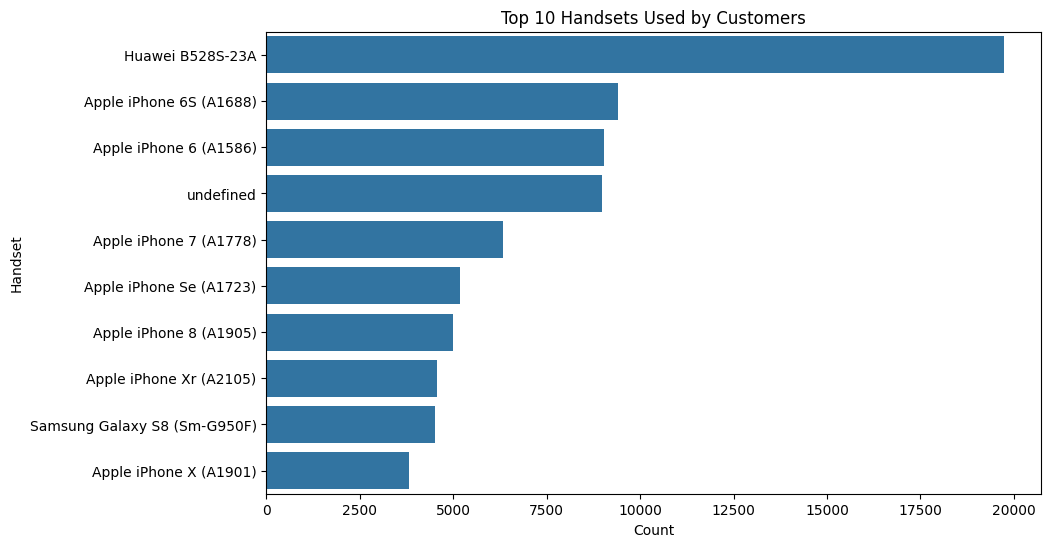

In [41]:
# Analyze and visualize top handsets using 'Handset Type'
top_handsets = df['Handset Type'].value_counts().head(10).reset_index()
top_handsets.columns = ['handset', 'count']

# Visualize top handsets
plot_top_handsets(top_handsets)


In [52]:
# Top 5 manufacturers
top_manufacturers = df['Handset Manufacturer'].value_counts().head(5)
print("Top 5 Handset Manufacturers:")
print(top_manufacturers)

Top 5 Handset Manufacturers:
Handset Manufacturer
Apple                            59565
Samsung                          40839
Huawei                           34423
undefined                         8987
Sony Mobile Communications Ab      980
Name: count, dtype: int64


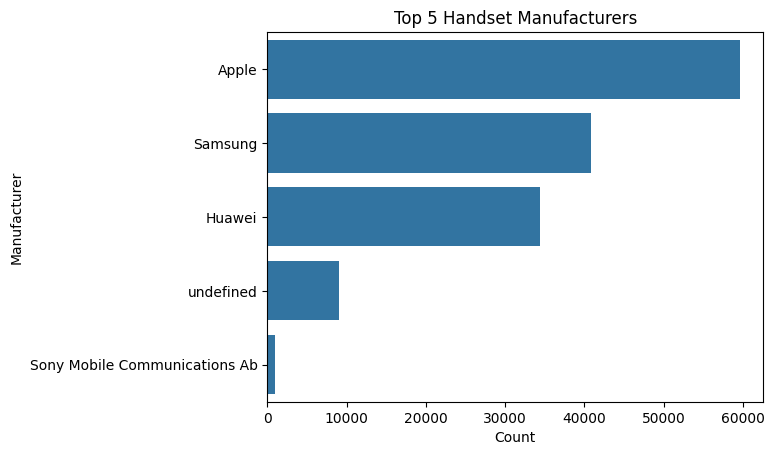

In [53]:
sns.barplot(x=top_manufacturers.values, y=top_manufacturers.index)
plt.title('Top 5 Handset Manufacturers')
plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.show()


Dispersion Parameters (Variance and Standard Deviation):
Bearer Id                                   8.315146e+36
Start ms                                    8.329624e+04
End ms                                      8.299970e+04
Dur. (ms)                                   3.490941e+09
IMSI                                        1.541087e+17
MSISDN/Number                               1.247919e+15
IMEI                                        5.005776e+26
Avg RTT DL (ms)                             2.638026e+03
Avg RTT UL (ms)                             1.219019e+02
Avg Bearer TP DL (kbps)                     2.954738e+08
Avg Bearer TP UL (kbps)                     9.921234e+05
TCP DL Retrans. Vol (Bytes)                 1.139304e+14
TCP UL Retrans. Vol (Bytes)                 1.299826e+11
DL TP < 50 Kbps (%)                         6.829870e+01
50 Kbps < DL TP < 250 Kbps (%)              1.283314e+01
250 Kbps < DL TP < 1 Mbps (%)               1.065051e+00
DL TP > 1 Mbps (%)            

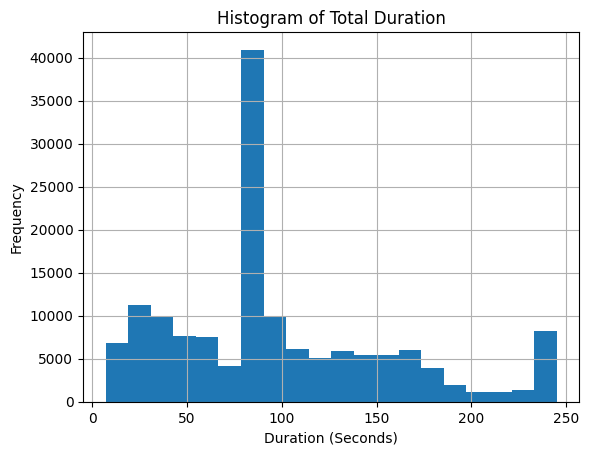

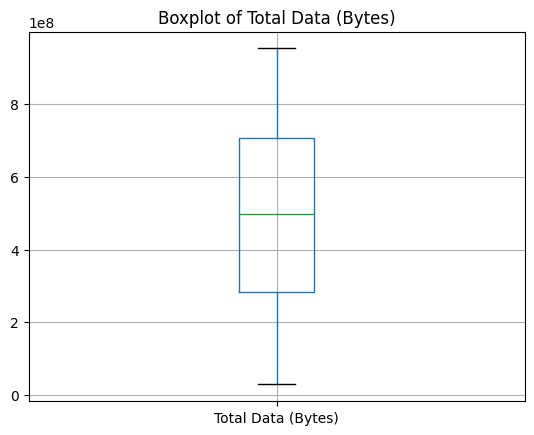

In [47]:
# Non-graphical analysis: Dispersion parameters
print("\nDispersion Parameters (Variance and Standard Deviation):")
print(df.var(numeric_only=True))
print(df.std(numeric_only=True))

# Graphical analysis: Histograms and boxplots for key variables
import matplotlib.pyplot as plt
df['Total Duration'].hist(bins=20)
plt.title("Histogram of Total Duration")
plt.xlabel("Duration (Seconds)")
plt.ylabel("Frequency")
plt.show()

df.boxplot(column='Total Data (Bytes)')
plt.title("Boxplot of Total Data (Bytes)")
plt.show()


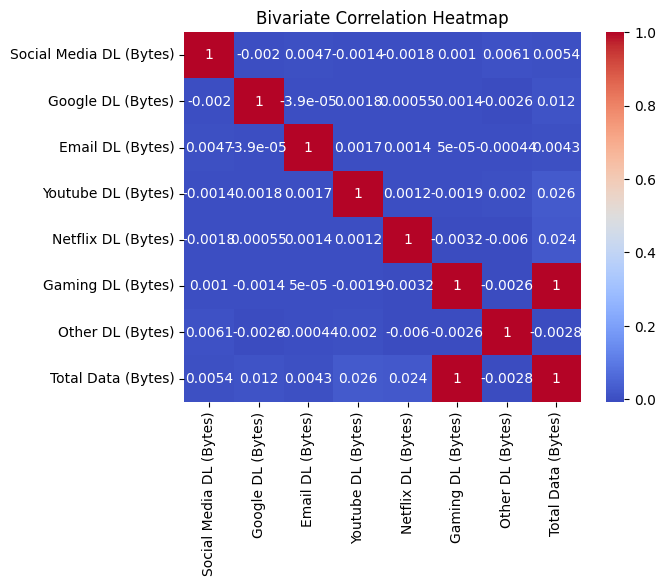

In [48]:
# Relationship between application usage and total data
application_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                       'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

bivariate_data = df[application_columns + ['Total Data (Bytes)']].corr()

# Visualize bivariate relationships
import seaborn as sns
sns.heatmap(bivariate_data, annot=True, cmap='coolwarm')
plt.title("Bivariate Correlation Heatmap")
plt.show()


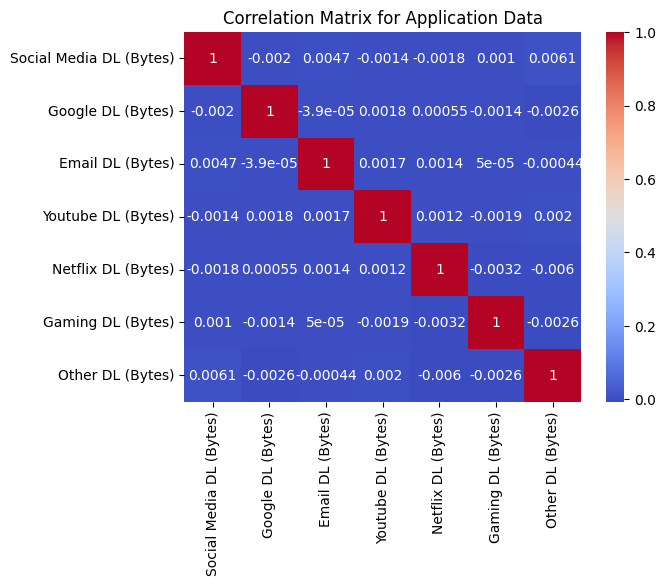

In [49]:
# Compute correlation matrix for key applications
correlation_matrix = df[application_columns].corr()

# Plot correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Application Data")
plt.show()



Explained Variance by Principal Components:
[0.14439453 0.14355429]


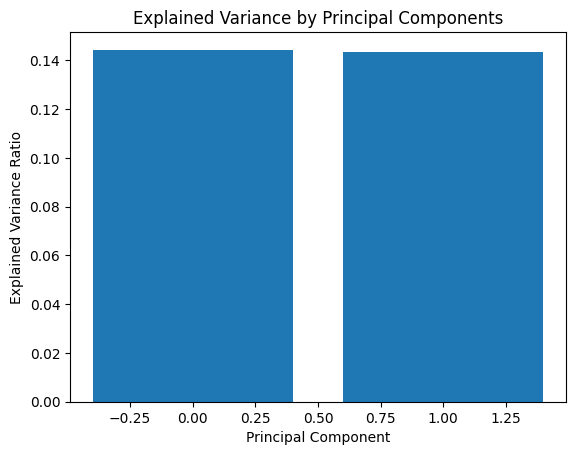

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[application_columns])

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Visualize PCA results
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance by Principal Components:")
print(explained_variance_ratio)

plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()
